PDHG algorithm

In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN , gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
import time

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
from modopt.math.metrics import ssim

import numpy as np
import matplotlib.pyplot as plt

## Import data and add noise

### Fourier operator and noise

In [43]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data+0j*u0.data

n=u0_mat.shape[0]
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

# Adding noise
(n1,n2) = u0.shape
s = 1e-6
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(u0_mat)+s*np.random.randn(2*n*n).view(np.complex128)

### Operators

In [44]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
p = np.zeros((n*n,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1

new_loc = kspace_loc[np.where(p)]
#pysap.Image(data = convert_locations_to_mask(np.array(new_loc),u0.shape)).show()

#Wavelet
linear_op = WaveletN(wavelet_name="db8",nb_scale=4,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

In [45]:
#ifft on noised data = base result
uk = fourier_op.adj_op(p*y)
print(ssim(uk,u0_mat))
pysap.Image(data = np.real(uk)).show()
pysap.Image(data = np.imag(uk)).show()

0.7613531350183936


## Reconstruction

In [46]:
# Specific files import
from algo.prox import prox_G,prox_F1_dual,prox_F2_dual
from algo.pdhg import pdhg
from algo.cost_utils import f1,f2,g

In [47]:
param = {"pn1":2e-6,"epsilon":1e-5,"gamma":1e-10}

In [48]:
print(g(u0_mat,param["epsilon"]),f2(linear_op.op(u0_mat),param["pn1"],param["gamma"]))

1.9073479506915347e-11 2.296999543905258e-07


In [49]:
# -- Solving --
# myconst = {"sigma":1.15,"tau":0.43}
uk,norms,energy,ssims = pdhg(y,p,fourier_op,linear_op,param,ground_truth=u0_mat,maxit=200)

10  iterations:
Cost: 1.1603230055988853e-07 
Norm: 0.05957906010654581 

20  iterations:
Cost: 1.1136617491889166e-07 
Norm: 0.006314040077735877 

30  iterations:
Cost: 1.107875048061492e-07 
Norm: 0.0009990118819554047 

40  iterations:
Cost: 1.1072267214255466e-07 
Norm: 0.00018948048592051374 

Finished in 26.518193244934082 seconds.


In [51]:
#Showing
print(ssim(u0_mat,uk))
pysap.Image(data = np.imag(uk)).show()

0.9056330919467643


In [52]:
pysap.Image(data = np.abs(np.real(uk-u0_mat))).show()

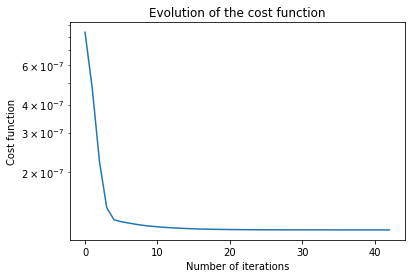

In [53]:
plt.plot(energy[1:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.title("Evolution of the cost function")
plt.yscale("log")
#plt.savefig("Comparisons/undecimated/pdhg/energy.png")
plt.show()

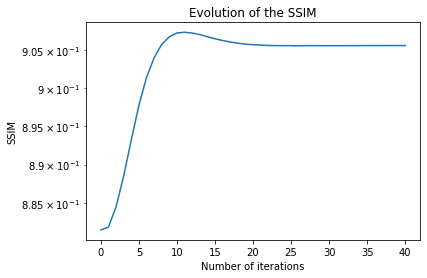

In [54]:
plt.plot(ssims[3:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("SSIM")
plt.title("Evolution of the SSIM")
plt.yscale("log")
#plt.savefig("Comparisons/undecimated/pdhg/metrics.png")
plt.show()

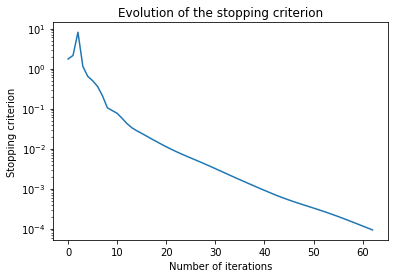

In [31]:
plt.plot(norms)
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("Stopping criterion")
plt.title("Evolution of the stopping criterion")
plt.yscale("log")
#plt.savefig("Comparisons/undecimated/pdhg/norms.png")
plt.show()

## Grid search over parameters

In [32]:
alphas = 1e-6*np.logspace(-1,1,7)
eps = 1e-5*np.logspace(-2,2,7)
ssims = np.zeros((7,7))
conv = np.zeros((7,7))
energies = np.zeros((7,7))

for i in range(7):
    for j in range(7):
        param["pn1"]=alphas[i]
        param["epsilon"]=eps[j]
        uk,norms,energy = pdhg(y,p,fourier_op,linear_op,param,maxit=30,verbose=0)
        
        energies[i,j]=energy[-1]
        conv[i,j]=norms[-1]
        ssims[i,j]=ssim(uk,u0_mat)
        print(f"({alphas[i]},{eps[j]}):\nssim:{ssims[i,j]}\nenergy:{energies[i,j]}\nnorm:{conv[i,j]}\n")

Finished in 16.72200918197632 seconds.
(1e-07,1.0000000000000001e-07):
ssim:0.6960841571281536
energy:1.4866539924118667e-08
norm:0.039470338774003993

Finished in 16.719056606292725 seconds.
(1e-07,4.641588833612778e-07):
ssim:0.7130247873391187
energy:1.3553511419193118e-08
norm:0.031785159539967585

Finished in 16.77766513824463 seconds.
(1e-07,2.1544346900318835e-06):
ssim:0.7220162441872845
energy:1.301841466457982e-08
norm:0.02567486968646776

Finished in 16.92851161956787 seconds.
(1e-07,1e-05):
ssim:0.7347070847093904
energy:1.2697473321813345e-08
norm:0.01958038095239836

Finished in 16.878268480300903 seconds.
(1e-07,4.641588833612778e-05):
ssim:0.7325088485004719
energy:1.2827983194510937e-08
norm:0.017193038408343655

Finished in 16.85902738571167 seconds.
(1e-07,0.00021544346900318823):
ssim:0.7232786124092835
energy:1.3418717881274039e-08
norm:0.016785669601928833

Finished in 16.93473196029663 seconds.
(1e-07,0.001):
ssim:0.7118299349710582
energy:1.5326215495212386e-08


No handles with labels found to put in legend.


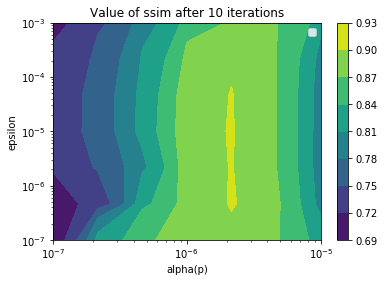

In [33]:
X,Y = np.meshgrid(alphas,eps)
const_to_test = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

plt.contourf(X,Y,ssims.transpose())
plt.title("Value of ssim after 10 iterations")
plt.xlabel("alpha(p)")
plt.ylabel("epsilon")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.legend()
#plt.savefig("Comparisons/sym8/pdhg/ssims.png")
plt.show()

In [34]:
print(alphas[np.argmax(ssims)//7],eps[np.argmax(ssims)%7])

2.154434690031883e-06 4.641588833612778e-07
